In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
import sklearn.metrics
import shap
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

loaded_model = pickle.load(open("mlruns/0/074a36d72b0647da88c0d2fc34a085b4/artifacts/model/model.pkl", 'rb'))
rf=loaded_model.best_estimator_

db = pd.read_csv('1_and_0/1.csv')
db["patient"] = 1
for i in range(2, 17):
    db1 = pd.read_csv('1_and_0/'+str(i)+'.csv')
    db1["patient"] = i
    db = pd.concat([db, db1])
# preprocess step
db.replace([np.inf, -np.inf], 1000, inplace=True)
db.fillna(db.mean(axis=0))
db.dropna(how='any', inplace=True)

Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator GridSearchCV from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in 

In [15]:

model_columns = ['interval_index', 'interval_start_time', 'mean_nni', 'sdnn', 'sdsd', 'nni_50', 'pnni_50', 'nni_20', 'pnni_20', 'rmssd', 'median_nni', 'range_nni', 'cvsd', 'cvnni', 'mean_hr', 'max_hr', 'min_hr', 'std_hr', 'lf', 'hf', 'vlf', 'lf_hf_ratio', 'csi', 'cvi', 'Modified_csi', 'sampen', 'sd1', 'sd2', 'ratio_sd2_sd1']
columns = model_columns + ["patient","filename",'label','timestamp']

shap_columns = [0]*len(model_columns)
for i in range(len(model_columns)):
    shap_columns[i] = "shap_values_"+columns[i]

def creation_database_grafana(columns,model_columns,database):
    explainer_patient = shap.TreeExplainer(rf)
    shap_values_graph = explainer_patient.shap_values(database[model_columns])

    
    
    grafana = pd.DataFrame(shap_values_graph[1],columns=shap_columns)
    grafana = grafana.join(database[columns].reset_index())
    return grafana,explainer_patient.expected_value[0]

df,expected_value = creation_database_grafana(columns,model_columns,db)

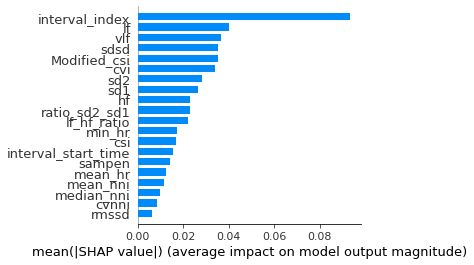

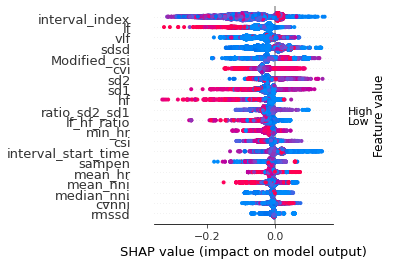

In [7]:
def plot_summary(db, model_columns):
    shap.summary_plot(db[shap_columns].values, db[model_columns].values,
                  plot_type="bar", feature_names=model_columns,plot_size=(4,4))


    shap.summary_plot(db[shap_columns].values, db[model_columns].values,
                  feature_names=model_columns, plot_type="dot",plot_size=(4,4))

plot_summary(df,model_columns)

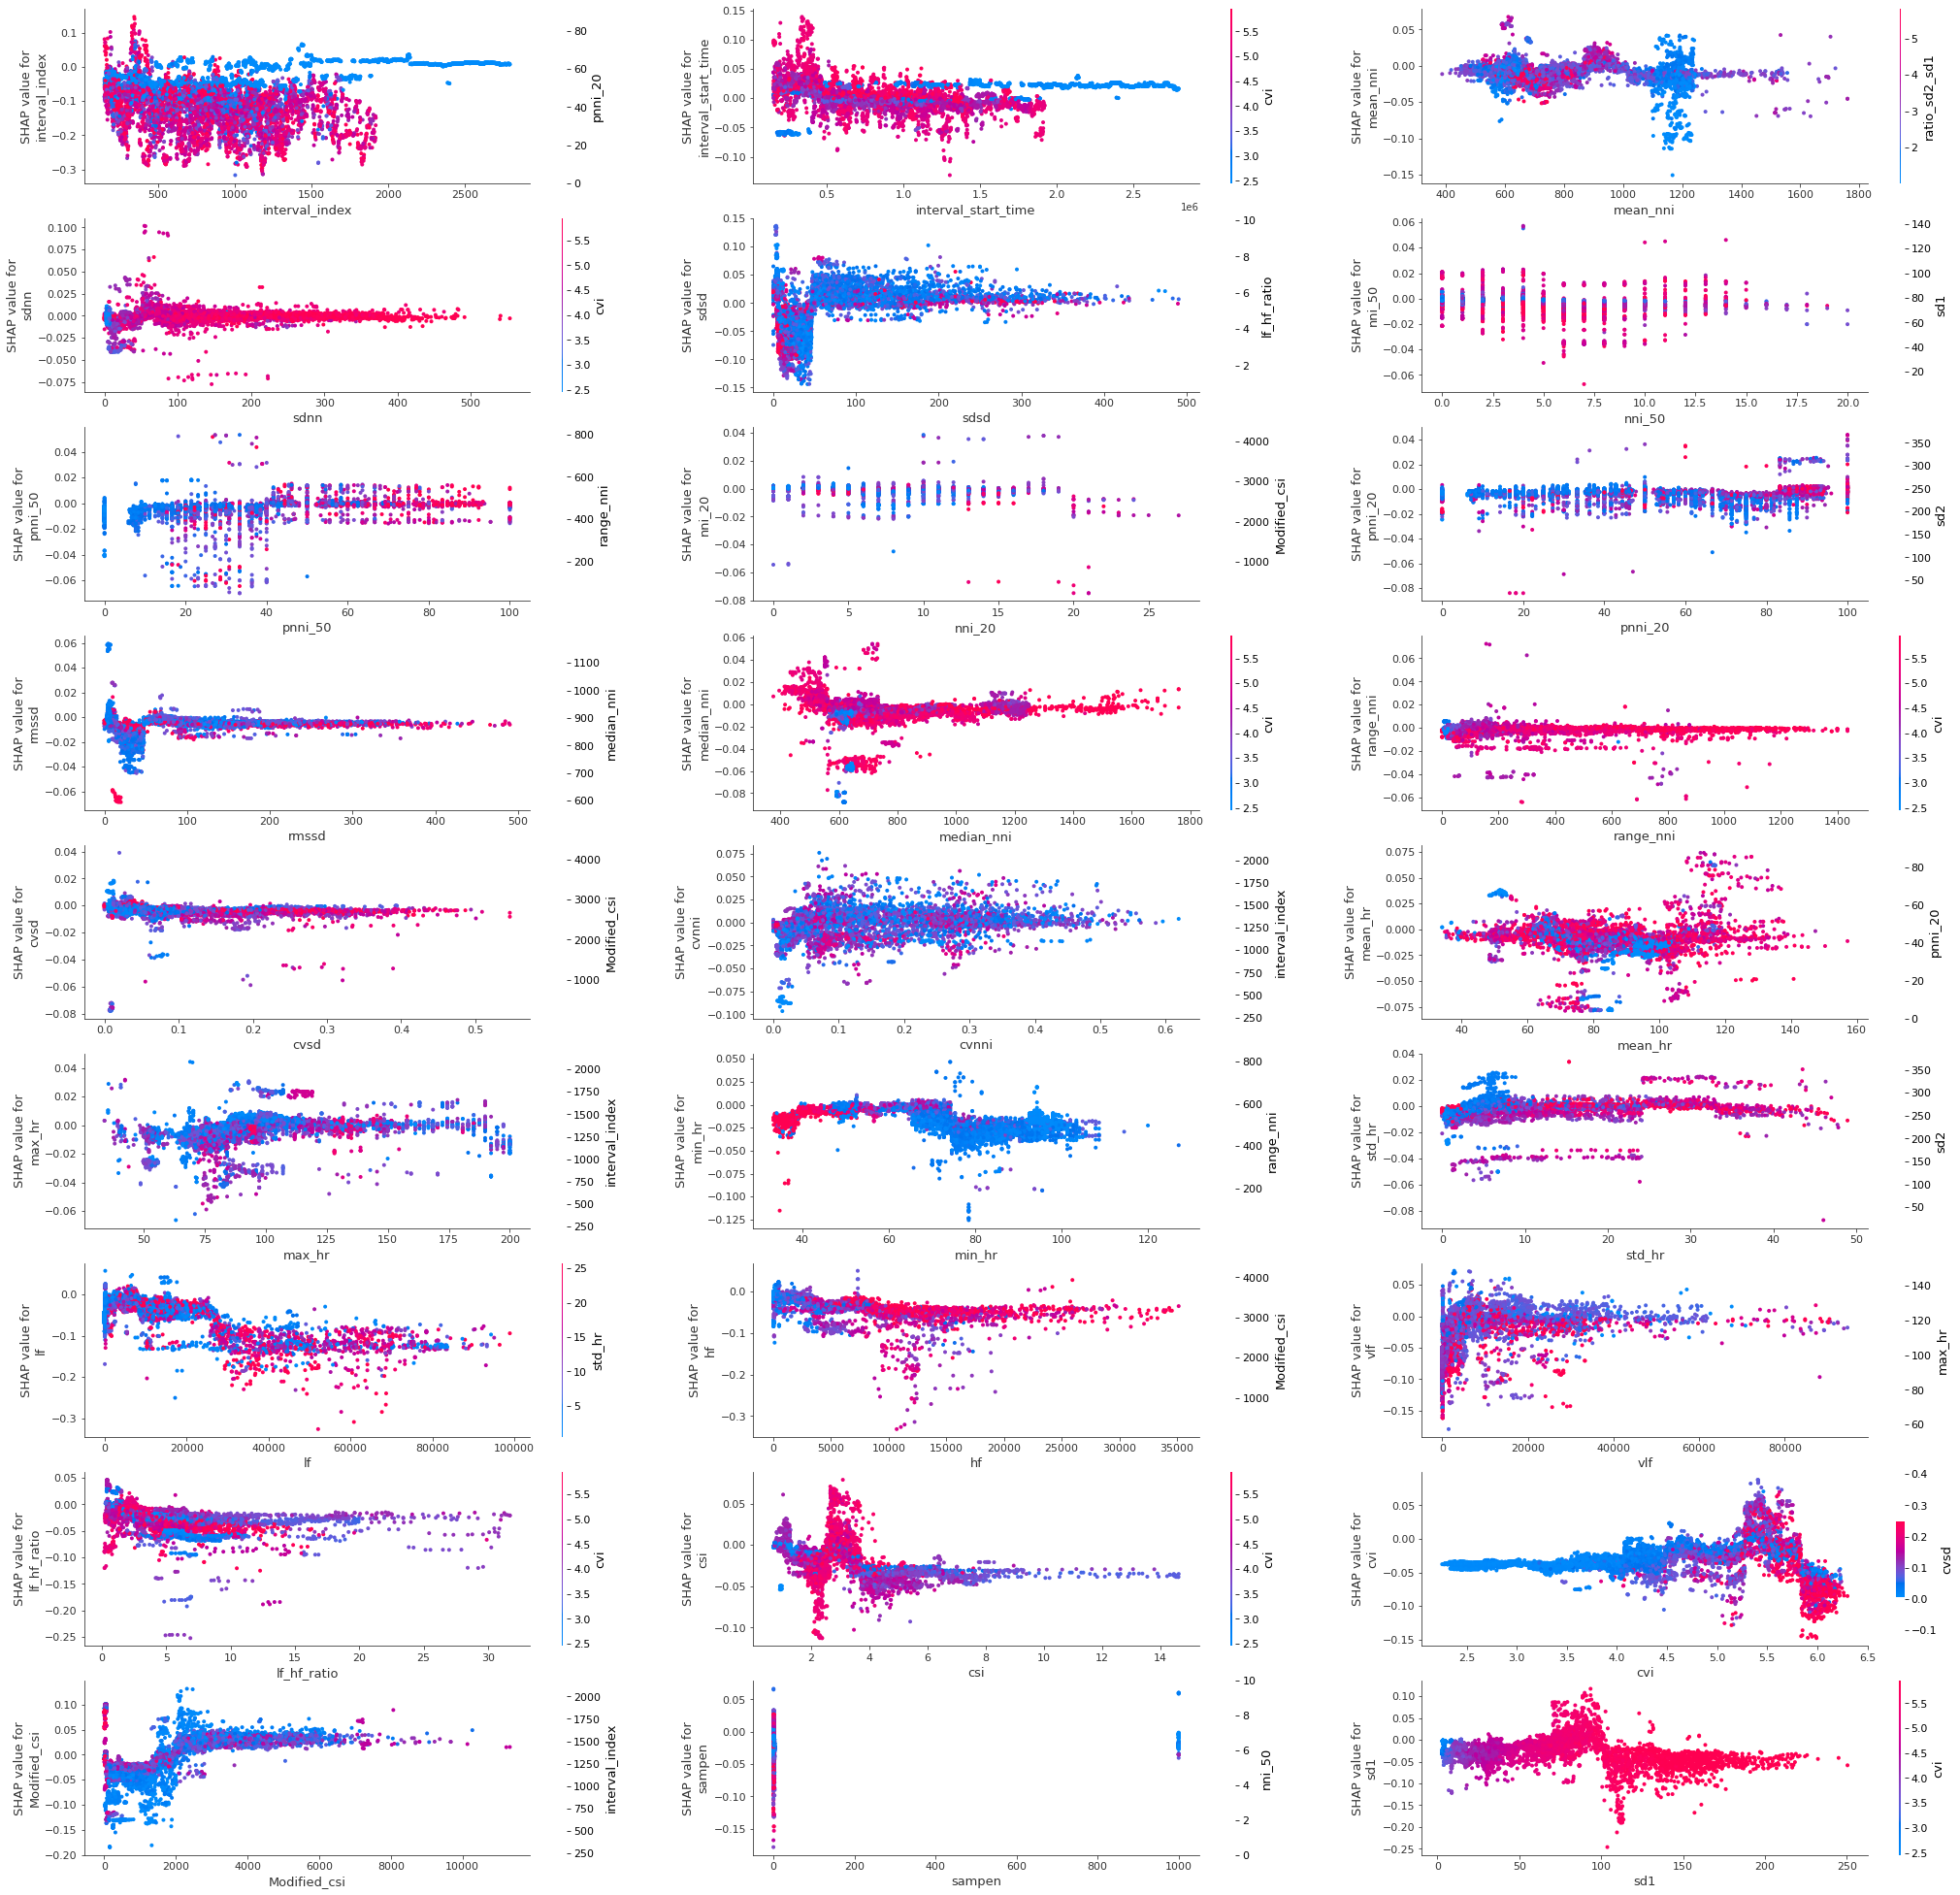

In [9]:
def plot_dependence(db, model_columns):
    fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(35, 35))
    axes = axes.ravel()


    for i in range(len(model_columns)):
        try:
            shap.dependence_plot(
            i, db[shap_columns].values, db[model_columns].values, feature_names=model_columns, show=False, ax=axes[i])
        except:
            None

plot_dependence(df,model_columns)      

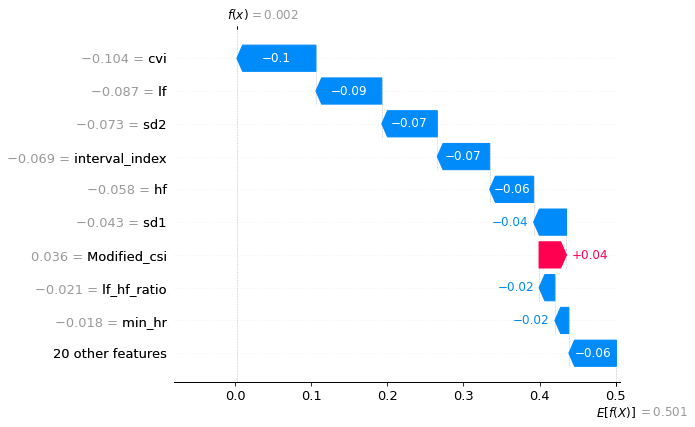

In [16]:
def plot_waterfall(db, model_columns, row,expected_value):
    shap.waterfall_plot(shap.Explanation(values=db[shap_columns].values[row],
                                     base_values=expected_value, data=db.iloc[row],
                                     feature_names=model_columns))

plot_waterfall(df, model_columns, 45,expected_value)

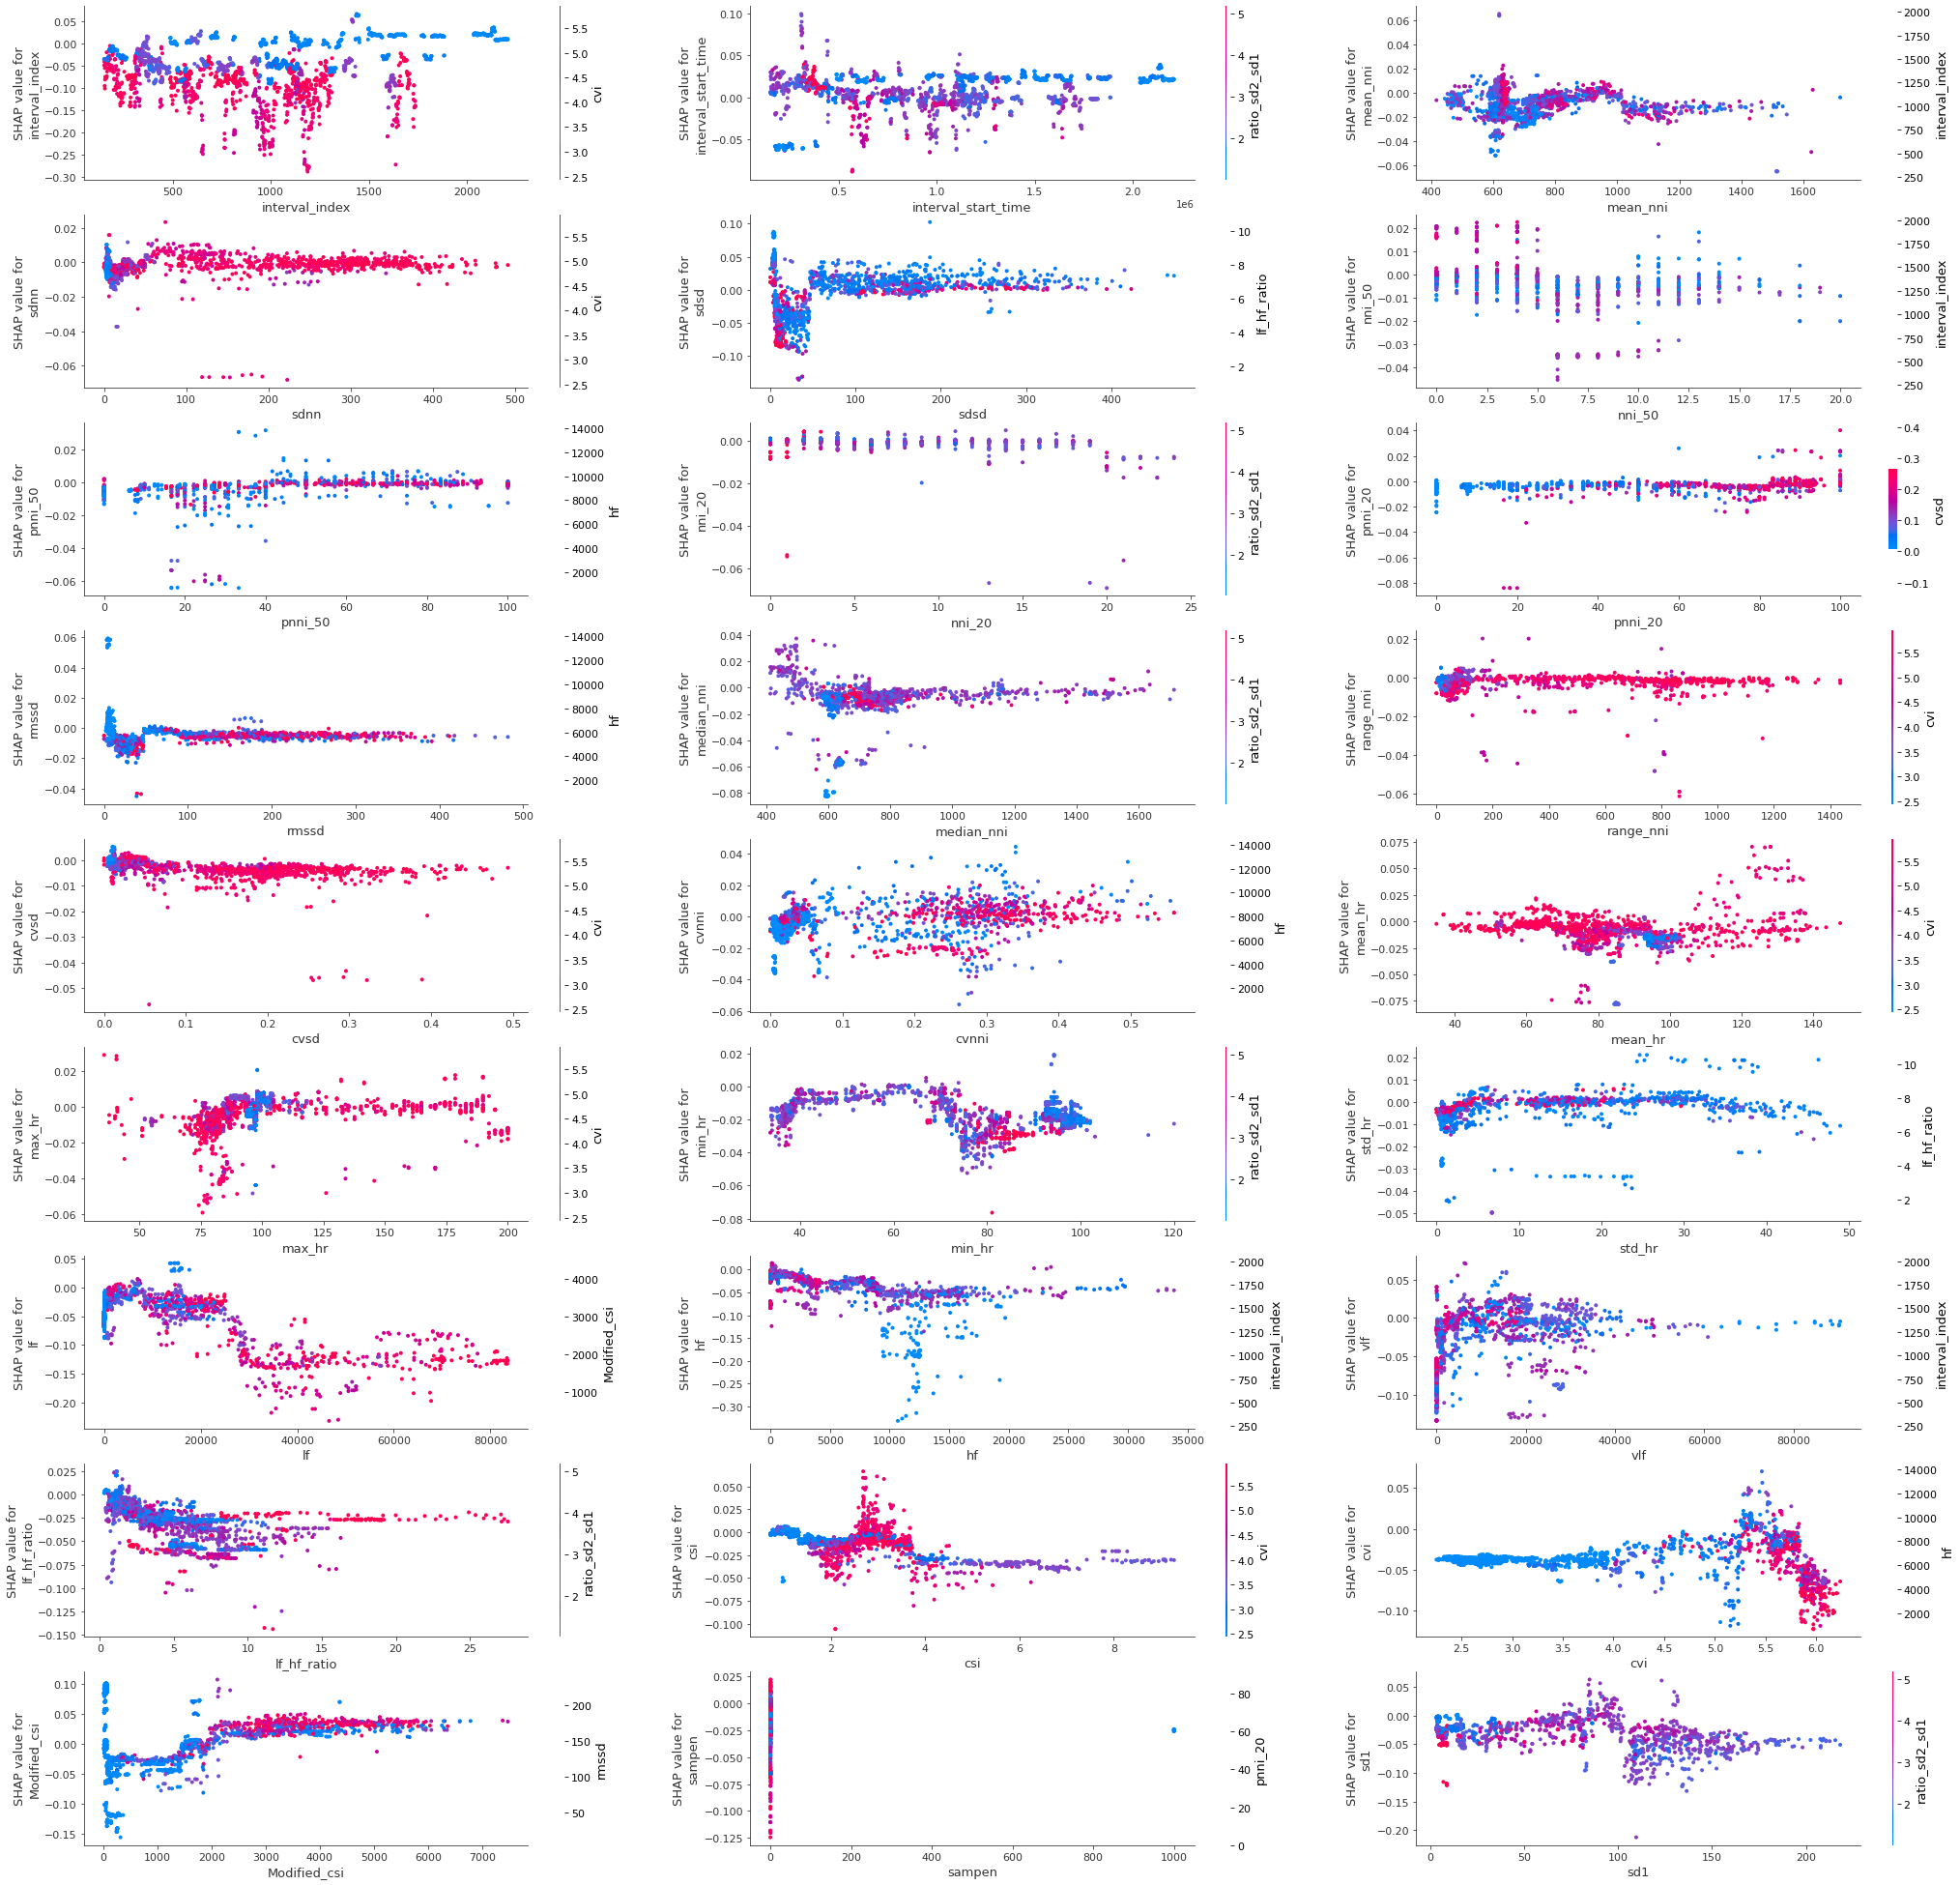

In [12]:
"""
Pour un patient spécifique ou plusieurs patients : plot_dependence(df[df["patient"]==1],model_columns) 
Pour certains labels : plot_dependence(df[df["label"]==1],model_columns) 
autres idées...
"""


plot_dependence(df[df["label"]==1],model_columns) 